First attempt at pulling data from Kaggle and recoding categorical variables of interest into dummy variables.

In [1]:
%matplotlib inline

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Structure
import numpy as np
import scipy as sp
import pandas as pd

# Machine Learning
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import log_loss
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale

# Others
from datetime import datetime
import re
import zipfile
import os.path

# Define Helper Functions

In [2]:
def print_full(statement):
    pd.set_option('display.max_rows', len(statement))
    print(statement)
    pd.reset_option('display.max_rows')

# Import Data

In [3]:
# Load the data and examine it
if os.path.isfile('./train.csv'):
    train_data = pd.read_csv('./train.csv')
else:
    z = zipfile.ZipFile('./train.csv.zip')
    train_data = pd.read_csv(z.open('train.csv'))

print("Shape of train_data:", train_data.shape)
train_data.head()

Shape of train_data: (878049, 9)


Dates        Category                      Descript  \
0  2015-05-13 23:53:00        WARRANTS                WARRANT ARREST   
1  2015-05-13 23:53:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
2  2015-05-13 23:33:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
3  2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   
4  2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   

   DayOfWeek PdDistrict      Resolution                    Address  \
0  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
1  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
2  Wednesday   NORTHERN  ARREST, BOOKED  VANNESS AV / GREENWICH ST   
3  Wednesday   NORTHERN            NONE   1500 Block of LOMBARD ST   
4  Wednesday       PARK            NONE  100 Block of BRODERICK ST   

            X          Y  
0 -122.425892  37.774599  
1 -122.425892  37.774599  
2 -122.424363  37.800414  
3 -122.426995  37.800873  
4 -122.438738  37.771541

In [4]:
if os.path.isfile('./test.csv'):
    test_data = pd.read_csv('./test.csv')
else:
    z = zipfile.ZipFile('./test.csv.zip')
    test_data = pd.read_csv(z.open('test.csv'))

print("Shape of test_data:", test_data.shape)
test_data.head()

Shape of test_data: (884262, 7)


Id                Dates DayOfWeek PdDistrict                   Address  \
0   0  2015-05-10 23:59:00    Sunday    BAYVIEW   2000 Block of THOMAS AV   
1   1  2015-05-10 23:51:00    Sunday    BAYVIEW        3RD ST / REVERE AV   
2   2  2015-05-10 23:50:00    Sunday   NORTHERN    2000 Block of GOUGH ST   
3   3  2015-05-10 23:45:00    Sunday  INGLESIDE  4700 Block of MISSION ST   
4   4  2015-05-10 23:45:00    Sunday  INGLESIDE  4700 Block of MISSION ST   

            X          Y  
0 -122.399588  37.735051  
1 -122.391523  37.732432  
2 -122.426002  37.792212  
3 -122.437394  37.721412  
4 -122.437394  37.721412

In [5]:
# Import San Francisco map for visualization
map_data = np.loadtxt("./sf_map_copyright_openstreetmap_contributors.txt")
len_width_ratio = map_data.shape[0] * 1.0 / map_data.shape[1]

# Data Cleansing

In [6]:
#print 'Before data cleansing, the train data contain %d samples, the test data contain %d samples.' % \
#      (train_data.shape[0], test_data.shape[0])
print("Before data cleansing, the train data contain {0:d} samples, the test data contain {1:d} samples"
      .format(train_data.shape[0], test_data.shape[0]))

# Drop samples containing null fields
train_data = train_data.dropna()

# The boundaries of valid longitude and latitude
lon_lat_box = (-122.5247, -122.3366, 37.699, 37.8299)

# Drop samples containing invalide longitude and latitude
train_data = train_data[train_data.X > lon_lat_box[0]]
train_data = train_data[train_data.X < lon_lat_box[1]]
train_data = train_data[train_data.Y > lon_lat_box[2]]
train_data = train_data[train_data.Y < lon_lat_box[3]]

#print('After data cleansing, the train data contain %d samples, the test data contain %d samples.' % \
#      (train_data.shape[0], test_data.shape[0]))
print("After data cleansing, the train data contain {0:d} samples, the test data contain {1:d} samples"
      .format(train_data.shape[0], test_data.shape[0]))

Before data cleansing, the train data contain 878049 samples, the test data contain 884262 samples
After data cleansing, the train data contain 877982 samples, the test data contain 884262 samples


# Exploratory Data Analysis

There are %d crime categories.
LARCENY/THEFT                  174885
OTHER OFFENSES                 126165
NON-CRIMINAL                    92300
ASSAULT                         76872
DRUG/NARCOTIC                   53971
VEHICLE THEFT                   53772
VANDALISM                       44724
WARRANTS                        42206
BURGLARY                        36754
SUSPICIOUS OCC                  31412
MISSING PERSON                  25989
ROBBERY                         22999
FRAUD                           16679
FORGERY/COUNTERFEITING          10609
SECONDARY CODES                  9985
WEAPON LAWS                      8555
PROSTITUTION                     7484
TRESPASS                         7325
STOLEN PROPERTY                  4539
SEX OFFENSES FORCIBLE            4387
DISORDERLY CONDUCT               4318
DRUNKENNESS                      4280
RECOVERED VEHICLE                3138
KIDNAPPING                       2341
DRIVING UNDER THE INFLUENCE      2268
RUNAWAY            

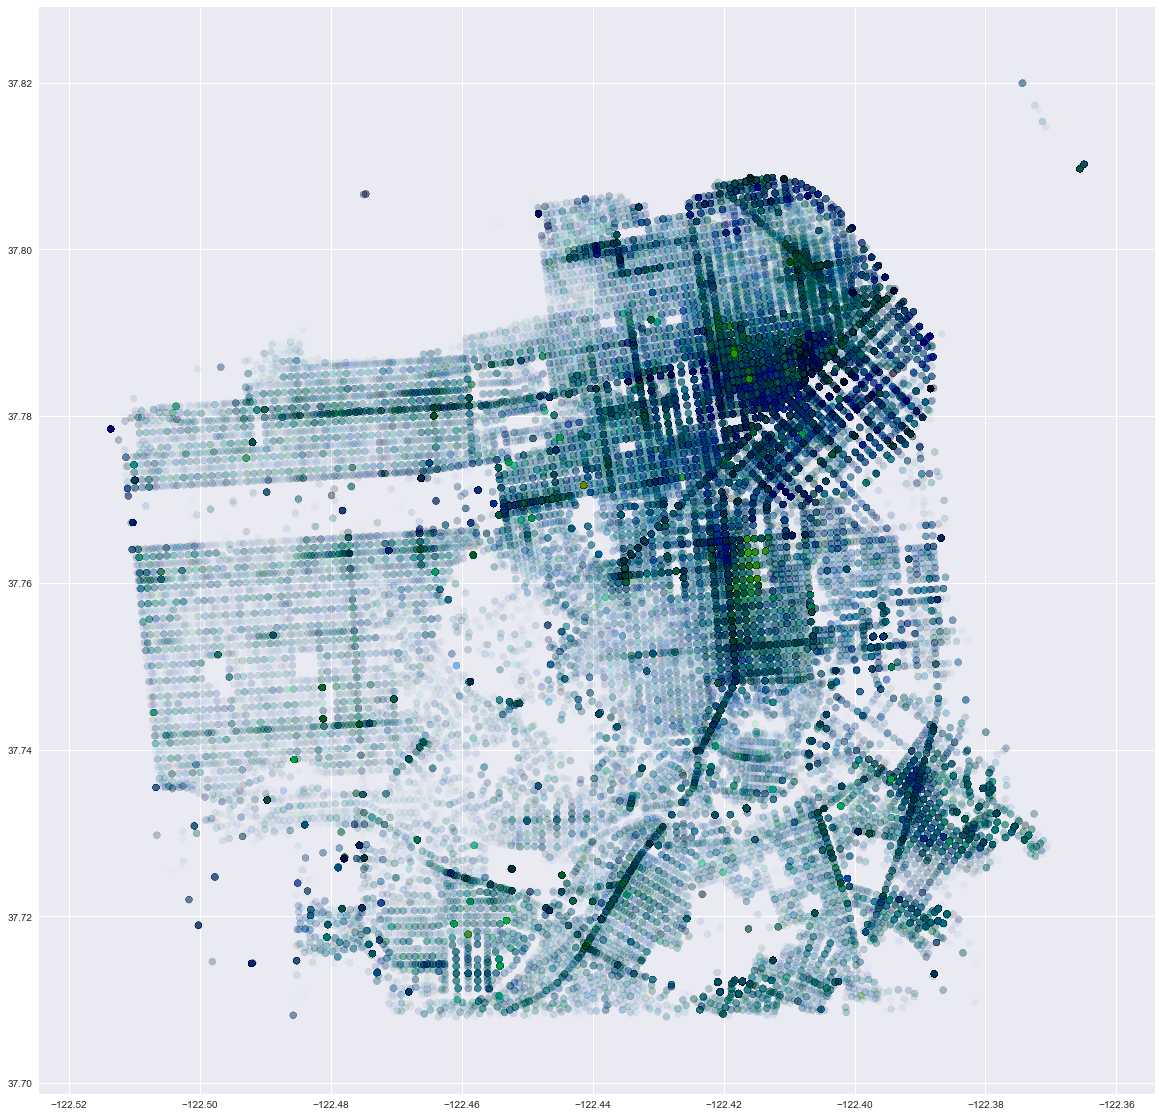

In [7]:
# Show all available crime lables.
crime_categories = train_data['Category'].value_counts()
#print 'There are %d crime categories.' % (len(crime_categories))
print("There are %d crime categories.".format((len(crime_categories))))
print(crime_categories)
crime_category_names = crime_categories.index

# Assign a color index to each crime category
color_map = dict(zip(crime_category_names, range(len(crime_categories))))

# Draw a scatter plot to show the crimes distribution
plt.figure(figsize=(20,20))
plt.scatter(train_data.X, train_data.Y, c=train_data.Category.map(color_map), cmap=plt.cm.gist_ncar, alpha = 0.01)

Apparently, the scatter plot with all crimes is not very helpful. Crimes happened everywhere, and we didn't get deeper insight. We will make the scatter plot of every crime separatedly at the next step.

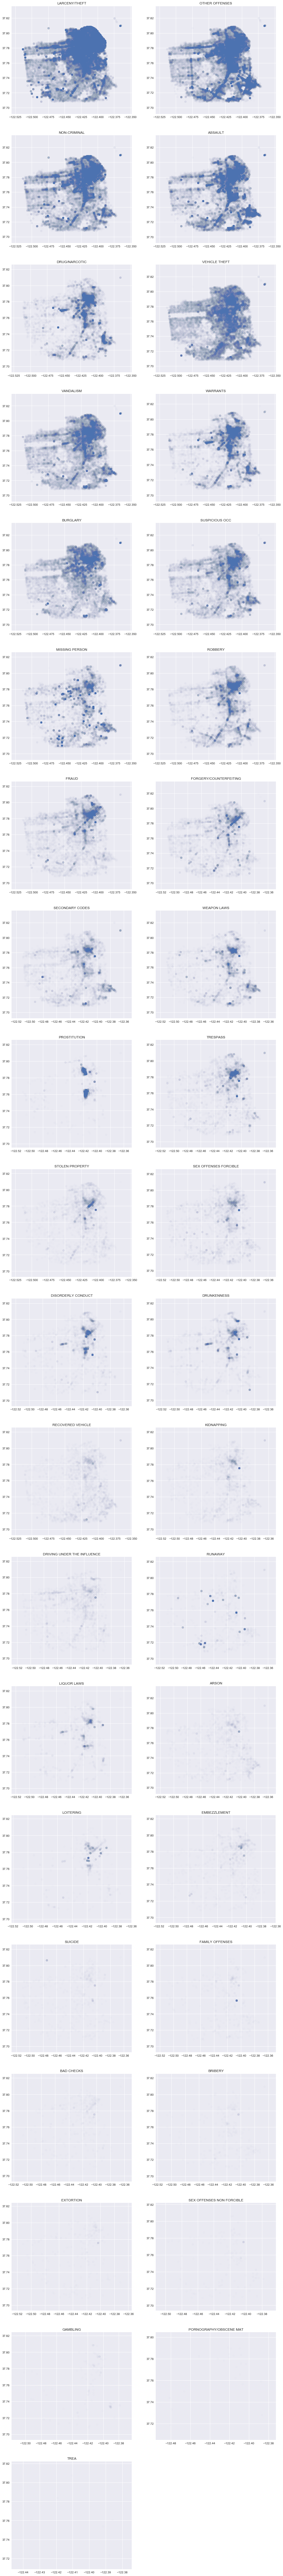

In [10]:
plt.figure(figsize=(16, 320))

for i in range(len(crime_category_names)):
    p = plt.subplot(40, 2, i+1)
    crime = crime_category_names[i]
    cur_crime_data = train_data[train_data.Category == crime]
    plt.title(crime)
    p.scatter(cur_crime_data.X, cur_crime_data.Y, alpha = 0.01)

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 877982 entries, 0 to 878048
Data columns (total 9 columns):
Dates         877982 non-null object
Category      877982 non-null object
Descript      877982 non-null object
DayOfWeek     877982 non-null object
PdDistrict    877982 non-null object
Resolution    877982 non-null object
Address       877982 non-null object
X             877982 non-null float64
Y             877982 non-null float64
dtypes: float64(2), object(7)
memory usage: 67.0+ MB


In [9]:
# Show all available crime lables.
print(train_data['Category'].value_counts())

# Show the percentage of the mode in all data. If the prediction of the model is worse than always predicting the mode,
# then we should always predict the mode in the baseline establishment.
print('There are %d crime types' % (len(train_data['Category'].value_counts())))
print('The percentage of the LARCENY/THEFT is: ', train_data['Category'].value_counts()[0] * 1.0 / train_data.shape[0])

LARCENY/THEFT                  174885
OTHER OFFENSES                 126165
NON-CRIMINAL                    92300
ASSAULT                         76872
DRUG/NARCOTIC                   53971
VEHICLE THEFT                   53772
VANDALISM                       44724
WARRANTS                        42206
BURGLARY                        36754
SUSPICIOUS OCC                  31412
MISSING PERSON                  25989
ROBBERY                         22999
FRAUD                           16679
FORGERY/COUNTERFEITING          10609
SECONDARY CODES                  9985
WEAPON LAWS                      8555
PROSTITUTION                     7484
TRESPASS                         7325
STOLEN PROPERTY                  4539
SEX OFFENSES FORCIBLE            4387
DISORDERLY CONDUCT               4318
DRUNKENNESS                      4280
RECOVERED VEHICLE                3138
KIDNAPPING                       2341
DRIVING UNDER THE INFLUENCE      2268
RUNAWAY                          1946
LIQUOR LAWS 

# Feature engineering

In [10]:
# Transform the Date into a python datetime object.
train_data["Dates"] = pd.to_datetime(train_data["Dates"], format="%Y-%m-%d %H:%M:%S")
test_data["Dates"] = pd.to_datetime(test_data["Dates"], format="%Y-%m-%d %H:%M:%S")

In [11]:
# Add Minute
train_data["Minute"] = train_data["Dates"].map(lambda x: x.minute)
test_data["Minute"] = test_data["Dates"].map(lambda x: x.minute)
    
print(sorted(train_data['Minute'].unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]


In [12]:
# Add Hour
train_data["Hour"] = train_data["Dates"].map(lambda x: x.hour)
test_data["Hour"] = test_data["Dates"].map(lambda x: x.hour)
    
print(sorted(train_data['Hour'].unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [13]:
# Add Month
train_data["Month"] = train_data["Dates"].map(lambda x: x.month - 1)
test_data["Month"] = test_data["Dates"].map(lambda x: x.month - 1)
    
print(sorted(train_data['Month'].unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


In [14]:
# Add Year
train_data["Year"] = train_data["Dates"].map(lambda x: x.year - 2003)   
test_data["Year"] = test_data["Dates"].map(lambda x: x.year - 2003)

print(sorted(train_data['Year'].unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [15]:
# Add Hour Zone
def get_hour_zone(hour):
    if hour >= 2 and hour < 8: 
        return 0;
    if hour >= 8 and hour < 12: 
        return 1;
    if hour >= 12 and hour < 18: 
        return 2;
    if hour >= 18 and hour < 22: 
        return 3;
    if hour < 2 or hour >= 22: 
        return 4;
    
train_data["Hour_Zone"] = train_data["Hour"].apply(get_hour_zone)
test_data["Hour_Zone"] = test_data["Hour"].apply(get_hour_zone)

print(sorted(train_data['Hour_Zone'].unique()))

[0, 1, 2, 3, 4]


In [16]:
# Add Week of Year
train_data["WeekOfYear"] = train_data["Dates"].map(lambda x: x.weekofyear / 2 - 1)
test_data["WeekOfYear"] = test_data["Dates"].map(lambda x: x.weekofyear / 2)

print(sorted(train_data['WeekOfYear'].unique()))
print(sorted(test_data['WeekOfYear'].unique()))

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0]
[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5, 22.5, 23.5, 24.5, 25.5, 26.5]


In [ ]:
# Transform the DayOfWeek to catogorical data
dayofweek_encoder = LabelEncoder()
dayofweek_encoder.fit(train_data['DayOfWeek'])

train_data["DayOfWeek_Category"] = dayofweek_encoder.transform(train_data['DayOfWeek'])
test_data["DayOfWeek_Category"] = dayofweek_encoder.transform(test_data['DayOfWeek'])

print(sorted(train_data['DayOfWeek_Category'].unique()))

train_data["Is_Weekday"] = train_data["DayOfWeek"].map(lambda day: 1 if day in set(['Sunday', 'Saturday']) else 0)
test_data["Is_Weekday"] = test_data["DayOfWeek"].map(lambda day: 1 if day in set(['Sunday', 'Saturday']) else 0)

print(sorted(train_data['Is_Weekday'].unique()))

[0, 1, 2, 3, 4, 5, 6]
[0, 1]


In [ ]:
# Add the street names as new feature. The address either contains one street, or it the intersection of two streets.
print('Before Transformation:')
print_full(train_data['Address'].head(20))

def extract_street1(address, seen_streets=None):
    street1 = address.split(' / ')[0]
    if seen_streets is None or street1 in seen_streets:
        return street1
    else:
        return 'None'

def extract_street2(address, seen_streets=None):
    streets = address.split(' / ')
    street2 = 'None' if len(streets) == 1 else streets[1]
    if seen_streets is None or street2 in seen_streets:
        return street2
    else:
        return 'None'

# Remove the block number from the address and divide the address into street1 and street2
re_pattern = '[0-9]+ Block of '
addresses = train_data["Address"].map(lambda address: re.sub(re_pattern, '', address))
train_data["Street1"] = addresses.apply(extract_street1)
train_data["Street2"] = addresses.apply(extract_street2)

seen_streets = set(train_data['Street1'].append(train_data['Street2']).unique())
seen_streets.discard('None')
print('\nThe number of unique streets in the train data is %d' % (len(seen_streets),))
print('There are %d unique street1 values, %d unique street2 value\n' % (train_data['Street1'].nunique(), 
                                                                         train_data['Street2'].nunique()))
addresses = test_data["Address"].map(lambda address: re.sub(re_pattern, '', address))
test_data["Street1"] = addresses.apply(extract_street1, args=(seen_streets,))
test_data["Street2"] = addresses.apply(extract_street2, args=(seen_streets,))

print('After Transformation:')
print_full(train_data['Street1'].head(20))
print_full(train_data['Street2'].head(20))

# Transform the Address to catogorical data
street_encoder = LabelEncoder()
seen_streets = list(seen_streets) + ['None']
street_encoder.fit(seen_streets)
train_data["Street1"] = street_encoder.transform(train_data['Street1'])
train_data["Street2"] = street_encoder.transform(train_data['Street2'])
test_data["Street1"] = street_encoder.transform(test_data['Street1'])
test_data["Street2"] = street_encoder.transform(test_data['Street2'])

# Exchange street1 and stree2 values to ensure that scale value of street1 is smaller greater than street2
# This step is to avoid the model from thinking "street1, street2" != "street2, street1"
for index, row in train_data.iterrows():
    if row['Street1'] > row['Street2']:
        row['Street1'], row['Street2'] = row['Street2'], row['Street1']

for index, row in test_data.iterrows():
    if row['Street1'] > row['Street2']:
        row['Street1'], row['Street2'] = row['Street2'], row['Street1']

Before Transformation:
0                OAK ST / LAGUNA ST
1                OAK ST / LAGUNA ST
2         VANNESS AV / GREENWICH ST
3          1500 Block of LOMBARD ST
4         100 Block of BRODERICK ST
5               0 Block of TEDDY AV
6               AVALON AV / PERU AV
7          KIRKWOOD AV / DONAHUE ST
8              600 Block of 47TH AV
9     JEFFERSON ST / LEAVENWORTH ST
10    JEFFERSON ST / LEAVENWORTH ST
11            0 Block of ESCOLTA WY
12               TURK ST / JONES ST
13           FILLMORE ST / GEARY BL
14         200 Block of WILLIAMS AV
15            0 Block of MENDELL ST
16               EDDY ST / JONES ST
17           GODEUS ST / MISSION ST
18           MENDELL ST / HUDSON AV
19            100 Block of JONES ST
Name: Address, dtype: object

The number of unique streets in the train data is 2075
There are 2033 unique street1 values, 1691 unique street2 value

After Transformation:
0           OAK ST
1           OAK ST
2       VANNESS AV
3       LOMBARD ST
4     BRO

In [ ]:
# Add the address type as a categorical feature 
valid_street_types = ['AL', 'AV', 'BL', 'BU', 'CR', 'CT', 'DR', 'EX', 'FE', 'HW', 'HY', 'LN', 'MA',
                      'PA', 'PL', 'PZ', 'RD', 'RW', 'ST', 'TE', 'TR', 'WA', 'WK', 'WY']
street_type_encoder = LabelEncoder()
street_type_encoder.fit(valid_street_types + ['OT'])

train_streets = street_encoder.inverse_transform(train_data["Street1"])
train_streets = train_streets.reshape(train_streets.shape[0], 1)
train_street_types = np.apply_along_axis(lambda street: street[0].split()[-1], 1, train_streets)
train_street_types = train_street_types.reshape(train_street_types.shape[0], 1)
train_street_types = np.apply_along_axis(lambda street_type: street_type if street_type in valid_street_types else 'OT', 
                                         1, train_street_types)

train_data['Street_Type'] = street_type_encoder.transform(train_street_types.reshape(train_street_types.shape[0], 1))
print(sorted(train_data['Street_Type'].unique()))

test_streets = street_encoder.inverse_transform(test_data["Street1"])
test_streets = test_streets.reshape(test_streets.shape[0], 1)
test_street_types = np.apply_along_axis(lambda street: street[0].split()[-1], 1, test_streets)
test_street_types = test_street_types.reshape(test_street_types.shape[0], 1)
test_street_types = np.apply_along_axis(lambda street_type: street_type if street_type in valid_street_types else 'OT', 
                                        1, test_street_types)

test_data['Street_Type'] = street_type_encoder.transform(test_street_types.reshape(test_street_types.shape[0], 1))
print(sorted(test_data['Street_Type'].unique()))

In [ ]:
# Whether the address locates at the intersection of two streets
train_data["Is_Intersection"] = train_data["Address"].map(lambda address: 0 if ' / ' in address else 1)
test_data["Is_Intersection"] = test_data["Address"].map(lambda address: 0 if ' / ' in address else 1)

print(sorted(train_data['Is_Intersection'].unique()))

[0, 1]


In [ ]:
# Whether the address locates at a block
train_data["Is_Block"] = train_data["Address"].map(lambda address: 0 if 'Block' in address else 1)
test_data["Is_Block"] = test_data["Address"].map(lambda address: 0 if 'Block' in address else 1)

print(sorted(train_data['Is_Block'].unique()))

[0, 1]


In [ ]:
# Transform the PdDistrict to catogorical data
discrict_encoder = LabelEncoder()
discrict_encoder.fit(train_data['PdDistrict'])

train_data["PdDistrict_Category"] = discrict_encoder.transform(train_data['PdDistrict'])
test_data["PdDistrict_Category"] = discrict_encoder.transform(test_data['PdDistrict'])

print(sorted(train_data['PdDistrict_Category'].unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [ ]:
# Normalize X and Y
print('There are {0:d} unique longitude values, {1:d} unique latitude values'.
      format(train_data['X'].nunique(), train_data['Y'].nunique()))
round_precision = 6
train_data['Long'] = train_data["X"].apply(round, args=(round_precision,))
train_data['Lat'] = train_data["Y"].apply(round, args=(round_precision,))
test_data['Long'] = test_data["X"].apply(round, args=(round_precision,))
test_data['Lat'] = test_data["Y"].apply(round, args=(round_precision,))

xy_scalar = preprocessing.StandardScaler().fit(train_data[['Long', 'Lat']])
train_data[['Long', 'Lat']] = xy_scalar.transform(train_data[['Long', 'Lat']])
test_data[['Long', 'Lat']] = xy_scalar.transform(test_data[['Long', 'Lat']])

There are 34242 unique longitude values, 34242 unique latitude values


In [ ]:
# X-Y plane rotation and system transformation to extract more spatial information
# Based on below functions:
# rotated x = xcos + ysin
# rotated y = ycos - xsin
# cardinal space -> polar space

train_data["Rot45_X"] = .707 * train_data['Lat'] + .707 * train_data['Long'] 
train_data["Rot45_Y"] = .707 * train_data['Lat'] - .707 * train_data['Long']
train_data["Rot30_X"] = (1.732/2) * train_data['Long'] + (1./2) * train_data['Lat'] 
train_data["Rot30_Y"] = (1.732/2) * train_data['Lat'] - (1./2) * train_data['Long']
train_data["Rot60_X"] = (1./2) * train_data['Long'] + (1.732/2) * train_data['Lat'] 
train_data["Rot60_Y"] = (1./2) * train_data['Lat'] - (1.732/2) * train_data['Long']
train_data["Radius"] = np.sqrt(train_data['Lat'] ** 2 + train_data['Long'] ** 2)
train_data["Theta"] = np.arctan2(train_data['Lat'], train_data['Long'])

test_data["Rot45_X"] = .707 * test_data['Lat'] + .707 * test_data['Long'] 
test_data["Rot45_Y"] = .707 * test_data['Lat'] - .707 * test_data['Long']
test_data["Rot30_X"] = (1.732/2) * test_data['Long'] + (1./2) * test_data['Lat'] 
test_data["Rot30_Y"] = (1.732/2) * test_data['Lat'] - (1./2) * test_data['Long']
test_data["Rot60_X"] = (1./2) * test_data['Long'] + (1.732/2) * test_data['Lat'] 
test_data["Rot60_Y"] = (1./2) * test_data['Lat'] - (1.732/2) * test_data['Long']
test_data["Radius"] = np.sqrt(test_data['Lat'] ** 2 + test_data['Long'] ** 2)
test_data["Theta"] = np.arctan2(test_data['Lat'], test_data['Long'])

In [ ]:
train_data.describe()

In [ ]:
# Transform Category to categorical data
criminal_labels = sorted(train_data['Category'].unique())
labels_map = dict(zip(criminal_labels, range(len(criminal_labels))))
train_data['Category_Num'] = train_data['Category'].map(labels_map)

# Train the model and testing

In [ ]:
train_data.info()

# Select the features to include in the prediction model
data_features = ['Minute', 'Hour', 'Month', 'Year', 'DayOfWeek_Category', 'Hour_Zone',
                 'Is_Weekday', 'Street1', 'Is_Intersection', 'Is_Block', 'PdDistrict_Category',
                 'Long', 'Lat', 'Street_Type', 'Rot45_X', 'Rot45_Y', 'Rot30_Y', 'Rot30_Y',
                 'Rot60_Y', 'Rot60_Y', 'Radius', 'Theta']

In [37]:
# Before we train the models, we need to divide the data into train data and dev data.
shuffle = np.random.permutation(np.arange(train_data.shape[0]))

shuffled_crime_data = train_data.iloc[shuffle]
shuffled_crime_data = shuffled_crime_data[data_features + ['Category_Num']]
shuffled_crime_data.info() 

mini_train_labels = shuffled_crime_data.iloc[:500000]['Category_Num']
mini_train_data = shuffled_crime_data.iloc[:500000].drop('Category_Num', axis=1)

mini_dev_labels = shuffled_crime_data.iloc[500000:]['Category_Num']
mini_dev_data = shuffled_crime_data.iloc[500000:].drop('Category_Num', axis=1)

print(mini_train_data.shape, mini_train_labels.shape, mini_dev_data.shape, mini_dev_labels.shape)

#original: 
#random_forest = RandomForestClassifier(max_features="log2", max_depth=18, n_estimators=50, min_samples_split=1000)
# after the first gridsearch with oob_score 
#random_forest = RandomForestClassifier(max_features=None, max_depth=15, 
#                                       n_estimators=50, min_samples_split=200, oob_score=False)
# after the second gridsearch without oob_score
random_forest = RandomForestClassifier(max_features=None, max_depth=50, 
                                       n_estimators=50, min_samples_split=200)

random_forest.fit(mini_train_data, mini_train_labels)
pred_probs = random_forest.predict_proba(mini_dev_data)
pred_labels = random_forest.predict(mini_dev_data)

rf_accuracy = np.mean(mini_dev_labels == pred_labels)
print('The accuracy of Random Forest model is {0:4f}'.format(rf_accuracy))

if mini_dev_labels.nunique() != pred_probs.shape[1]:
    print('Please run the cell again to get the multiclass loss.')
else:
    total_loss = log_loss(mini_dev_labels, pred_probs)
    print('The multiclass loss of Random Forest model is {0:4f}'.format(total_loss))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 877982 entries, 641182 to 230932
Data columns (total 23 columns):
Minute                 877982 non-null int64
Hour                   877982 non-null int64
Month                  877982 non-null int64
Year                   877982 non-null int64
DayOfWeek_Category     877982 non-null int64
Hour_Zone              877982 non-null int64
Is_Weekday             877982 non-null int64
Street1                877982 non-null int64
Is_Intersection        877982 non-null int64
Is_Block               877982 non-null int64
PdDistrict_Category    877982 non-null int64
Long                   877982 non-null float64
Lat                    877982 non-null float64
Street_Type            877982 non-null int64
Rot45_X                877982 non-null float64
Rot45_Y                877982 non-null float64
Rot30_Y                877982 non-null float64
Rot30_Y                877982 non-null float64
Rot60_Y                877982 non-null float64
Rot60_Y        

## Error Analysis

## Smoothing the predictions 
We are going to add a small value to all the predictions so that we don't have any 0 value probability.   
Note that while the $\sum{row_{predictions}} > {1}$ for each row of the prediction matrix, this is not an issue. Log_loss function used by Python and Kaggle rescales the matrix back to $\sum{row_{predictions}} = 1$.

In [68]:
# Smoothing the predictions 
# We are going to add a small value to 
# each probability and compute the log_loss score
pred_probs2 = pred_probs.copy()
x = []
y = []
for s in range(1, 100):
    smoothing = s*(10**-5) 
    x.append(smoothing)
    #print(smoothing)
    t3 = np.add(pred_probs2 , (np.ones(pred_probs2.shape)*smoothing))
    ll = log_loss(mini_dev_labels, t3)
    y.append(ll)
    #print(smoothing,ll)

We get the lowest log_loss score of: 2.290108, with smooting parameter: 0.000210
The improvement is 0.025258%


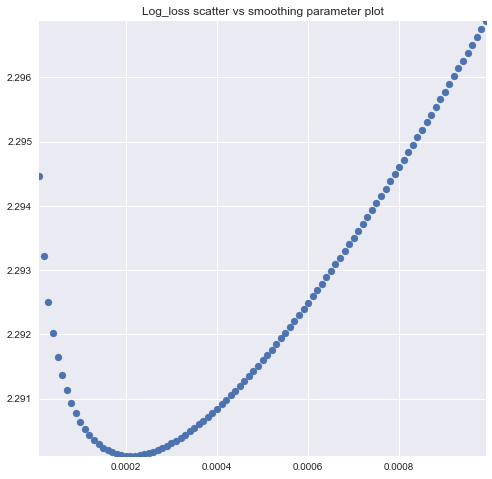

In [69]:
# Plotting the log_loss scores to find out the min value
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111)
ax.set_xlim(min(x),max(x))
ax.set_ylim(min(y),max(y))
plt.scatter(x,y)
plt.title('Log_loss scatter vs smoothing parameter plot')
min_value = np.argmin(y)

print("We get the lowest log_loss score of: {0:f}, with smooting parameter: {1:f}".
      format(y[min_value],x[min_value]))
print("The improvement is {0:3f}%".format(1-(y[min_value]/2.34945027229)))

# Tuning the model parameters

In [36]:
n_estimators = [5, 10, 25, 50]
max_features = ['sqrt', 'log2', None]
max_depth = [5, 10, 15, 20, 50]
min_samples_split = [200, 500, 1000]
#oob_score = [False, True]

# Warning: doing cross validation on large data set will be extremly time and memory consuming. It takes a computer
# with 16GB memory about 45-60 mins to run the cross validation model below. Carefully select the tunning parameters
# set before running.
cv_clf = GridSearchCV(RandomForestClassifier(), {'n_estimators': n_estimators, 
                                                 'max_features': max_features,
                                                 'max_depth': max_depth,
                                                 'min_samples_split': min_samples_split})
#                                                 'oob_score': False})

# The "optimal" parameters computed here may actually increase the submission score sometime, 
# probably due to overfitting.
cv_clf.fit(train_data[:50000][data_features], train_data[:50000]['Category_Num'])
print(cv_clf.best_params_)

/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


{'max_depth': 50, 'max_features': None, 'min_samples_split': 200, 'n_estimators': 50}


# Generate Submission Results

In [40]:
# We will use the Random Forest to establish the baseline.
# Retrain the Random Forest model with full train data
random_forest = RandomForestClassifier(max_features=None, max_depth=50, 
                                       n_estimators=50, min_samples_split=200)
random_forest.fit(train_data[data_features], train_data['Category_Num'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=200, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [41]:
transformed_test_data = test_data[data_features]
transformed_test_data.info()

predictions = random_forest.predict_proba(transformed_test_data)
print(predictions.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884262 entries, 0 to 884261
Data columns (total 22 columns):
Minute                 884262 non-null int64
Hour                   884262 non-null int64
Month                  884262 non-null int64
Year                   884262 non-null int64
DayOfWeek_Category     884262 non-null int64
Hour_Zone              884262 non-null int64
Is_Weekday             884262 non-null int64
Street1                884262 non-null int64
Is_Intersection        884262 non-null int64
Is_Block               884262 non-null int64
PdDistrict_Category    884262 non-null int64
Long                   884262 non-null float64
Lat                    884262 non-null float64
Street_Type            884262 non-null int64
Rot45_X                884262 non-null float64
Rot45_Y                884262 non-null float64
Rot30_Y                884262 non-null float64
Rot30_Y                884262 non-null float64
Rot60_Y                884262 non-null float64
Rot60_Y             

In [42]:
#Smoothing the predictions
predictions = np.add(predictions , (np.ones(predictions.shape)*0.000210))

In [43]:
# Generate the submission dataframe
submission = np.column_stack((range(predictions.shape[0]), predictions))
submission = pd.DataFrame(data=submission, columns=['Id'] + criminal_labels)
submission['Id'] = submission['Id'].astype(int)
submission.head()

Id     ARSON   ASSAULT  BAD CHECKS   BRIBERY  BURGLARY  DISORDERLY CONDUCT  \
0   0  0.005608  0.169983     0.00021  0.001738  0.021291            0.002035   
1   1  0.001649  0.079663     0.00021  0.000441  0.002874            0.006608   
2   2  0.006604  0.110498     0.00021  0.000291  0.099794            0.001085   
3   3  0.001805  0.226589     0.00021  0.000802  0.015793            0.002455   
4   4  0.001805  0.226589     0.00021  0.000802  0.015793            0.002455   

   DRIVING UNDER THE INFLUENCE  DRUG/NARCOTIC  DRUNKENNESS     ...       \
0                     0.007723       0.027377     0.004279     ...        
1                     0.007515       0.067414     0.001437     ...        
2                     0.004835       0.030041     0.002826     ...        
3                     0.001539       0.048304     0.011083     ...        
4                     0.001539       0.048304     0.011083     ...        

   SEX OFFENSES NON FORCIBLE  STOLEN PROPERTY   SUICIDE  SUSPICIOUS OCC  \
0                    0.00021         0.005146  0.001062        0.071447   
1                    0.00021         0.003308  0.000660        0.051781   
2                    0.00021         0.011183  0.000423        0.046455   
3                    0.00028         0.003188  0.000883        0.057588   
4                    0.00028         0.003188  0.000883        0.057588   

      TREA  TRESPASS  VANDALISM  VEHICLE THEFT  WARRANTS  WEAPON LAWS  
0  0.00021  0.009376   0.056543       0.044071  0.039849     0.017662  
1  0.00021  0.000509   0.011172       0.010774  0.093205     0.021632  
2  0.00021  0.006671   0.060310       0.040756  0.027429     0.009666  
3  0.00021  0.007949   0.061773       0.036535  0.082750     0.022818  
4  0.00021  0.007949   0.061773       0.036535  0.082750     0.022818  

[5 rows x 40 columns]

In [44]:
# Save the submission csv file
submission.to_csv('submission.csv.gz', index=False, compression='gzip')

In [45]:
submission.shape

(884262, 40)